Testing mapping coastlines for custom projections (i.e. those not supported by cartopy)

In [197]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pyproj import Proj, CRS

In [2]:
dirname_basemap = '/home/users/wkjones/python/basemap/lib/mpl_toolkits/basemap'
path_points = os.path.join(dirname_basemap, 'data', 'gshhs_c.dat')
path_meta = os.path.join(dirname_basemap, 'data', 'gshhsmeta_c.dat')

In [117]:
points_file = open(path_points, 'rb')
meta_file = open(path_meta,'r')
segments = []
npts_min=1
for line in meta_file:
    # kind=1 are continents, kind=2 are lakes
    kind, area, npts, lim_south, lim_north, startbyte, numbytes,\
    date_line_crossing = line.split()
    points_file.seek(int(startbyte))
    data = np.fromfile(points_file, '<f4', count = int(numbytes)//4)
    data = data.reshape(int(npts), 2)
    if npts_min < int(npts) and kind=='1':
        segments.append(data)

In [118]:
len(segments)

743

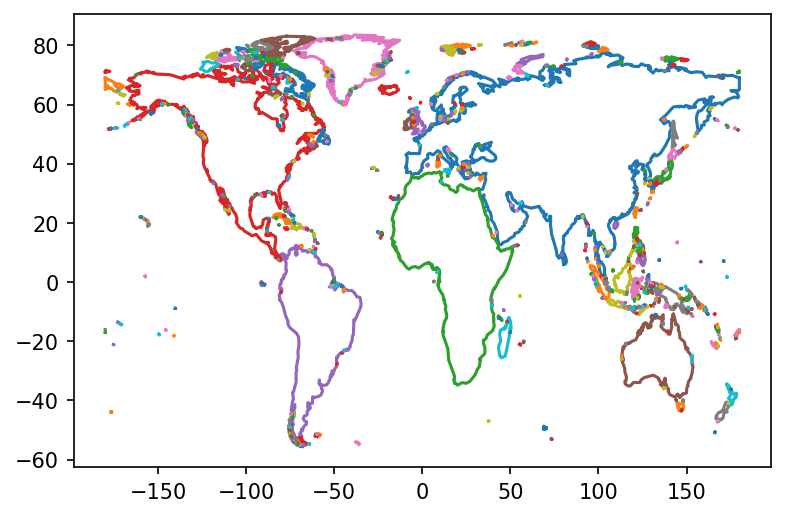

In [119]:
plt.figure(dpi=150)
for seg in segments:
    plt.plot(seg[:, 0], seg[:, 1])


In [164]:
# test_p = Proj(proj='ocea', lat_1=-75, lon_1=30, lat_2=75, lon_2=-150)
# test_p = Proj(proj='ocea', lonc=105, alpha=-75)
test_p = Proj(proj='ob_tran', o_proj='mill', o_lon_p=15, o_lat_p=75)

In [165]:
new_segments = [np.stack(test_p(seg[:, 0], seg[:, 1]),-1) for seg in segments]

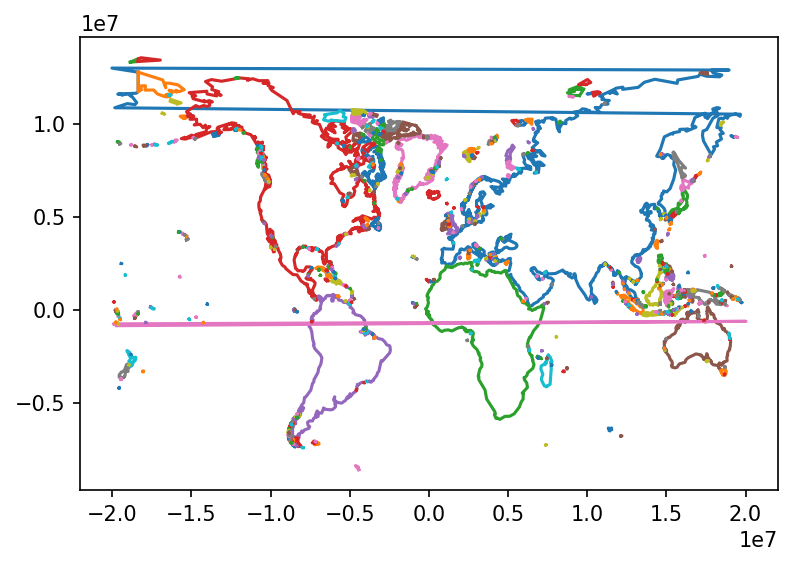

In [166]:
plt.figure(dpi=150)
for seg in new_segments:
    plt.plot(seg[:, 0], seg[:, 1])
#     plt.scatter(seg[:, 0], seg[:, 1], s=1)


In [170]:
blue_marble_file = os.path.join(dirname_basemap, 'data', 'bmng.jpg')
blue_marble = plt.imread(blue_marble_file)

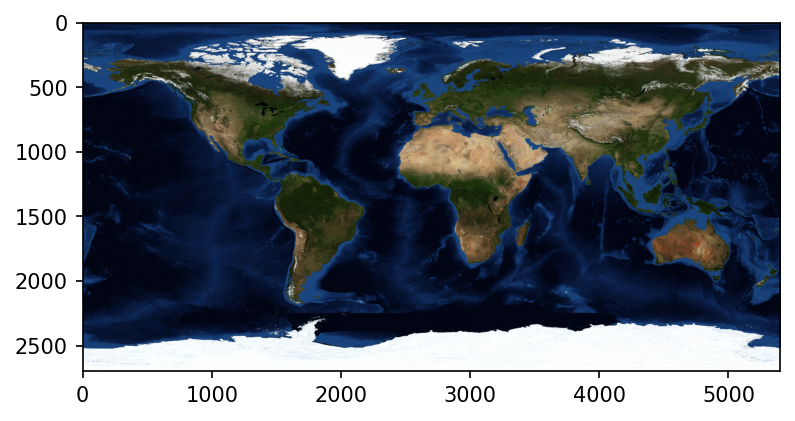

In [171]:
plt.figure(dpi=150)
plt.imshow(blue_marble)

In [172]:
blue_marble.shape

(2700, 5400, 3)

In [173]:
blue_marble.dtype

dtype('uint8')

In [175]:
out_img = np.full_like(blue_marble, 0)

In [178]:
lons, lats = np.meshgrid(np.linspace(-180,180,5401)[:-1]+360/5400, 
                         np.linspace(-90,90,2701)[:-1]+180/2700)

In [181]:
new_x, new_y = test_p(lons,lats)

new_xx, new_yy = np.meshgrid(np.linspace(np.nanmin(new_x), np.nanmax(new_x), 5400),
                             np.linspace(np.nanmin(new_y), np.nanmax(new_y), 2700))

In [185]:
old_lons, old_lats = test_p(new_xx, new_yy, inverse=True)
old_lons = (old_lons+180)/360*5400
old_lats = (old_lats+90)/180*2700

In [183]:
import cv2 as cv

In [196]:
out_img = cv.remap(blue_marble[::-1].astype(np.float32), 
                   old_lons.astype(np.float32), 
                   old_lats.astype(np.float32), 
                   cv.INTER_LINEAR, out_img, cv.BORDER_TRANSPARENT)[::-1]

TypeError: Expected Ptr<cv::UMat> for argument 'dst'

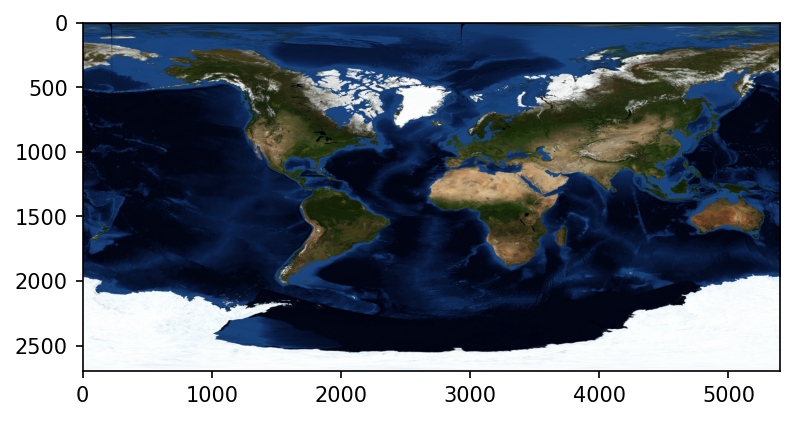

In [195]:
plt.figure(dpi=150)
plt.imshow(out_img.astype(int))

In [198]:
test_crs = CRS(proj='ob_tran', o_proj='mill', o_lon_p=15, o_lat_p=75)

In [204]:
test_crs.